In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(1)

GPU device: NVIDIA RTX A6000


In [2]:
import os
import pathlib
from typing import Tuple, List, Dict
from PIL import Image
import torch
from torch.utils.data import Dataset

class BinaryClassificationDataset(Dataset):
    def __init__(self, targ_dir: str, transform=None, target_transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*/*.png"))
        self.transform = transform
        self.target_transform = target_transform
        self.classes, self.class_to_idx = self.find_classes(targ_dir)
        
        self.non_distracted_classes = {'sitting_still', 'entering_car', 'exiting_car'}
        self.class_to_idx_binary = {cls_name: 0 if cls_name in self.non_distracted_classes else 1 for cls_name in self.classes}
        
        # Map binary labels to class names
        self.binary_label_to_class_name = {0: 'non_distracted', 1: 'distracted'}

        # Attribute for all binary labels of the dataset
        self.all_binary_labels = [self.class_to_idx_binary[path.parent.parent.name] for path in self.paths]

    def load_image(self, index: int) -> Image.Image:
        """
        Load an image at a given index as a grayscale image.

        :param index: Index of the image to load.
        :return: A PIL Image object in grayscale.
        """
        image_path = self.paths[index]
        # Open the image in grayscale mode
        image = Image.open(image_path).convert("L")
        return image

    def __len__(self) -> int:
        """
        Return the total number of images in the dataset.
        """
        return len(self.paths)

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """
        Find all unique classes in the target directory.

        :param directory: Path to the directory to search for classes.
        :return: A tuple of the list of class names and a mapping from class names to indices.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int, str, int]:
        """
        Get an item by index.

        :param index: Index of the item to get.
        :return: A tuple of the image tensor, binary class index, class index, and binary class name.
        """
        image = self.load_image(index)
        class_name = self.paths[index].parent.parent.name
        class_idx = self.class_to_idx[class_name]
        class_idx_binary = self.class_to_idx_binary[class_name]
        
        # Convert binary label to its corresponding class name
        class_name_binary = self.binary_label_to_class_name[class_idx_binary]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_idx_binary = self.target_transform(class_idx_binary)
        
        # Return the image, binary class index, class index, and binary class name
        return image, class_idx_binary, class_idx, class_name_binary

In [3]:
'''
    Analysis Claa Here
'''
import matplotlib.pyplot as plt

class BinaryClassificationDatasetAnalysis(BinaryClassificationDataset):
    def __init__(self, targ_dir: str, dataset_name='Dataset', dataset_split="split_0", transform=None, target_transform=None) -> None:
        super().__init__(targ_dir, transform, target_transform)
        self.dataset_name = dataset_name  # Attribute to store the name of the dataset
        self.dataset_split_name = dataset_split

    def count_samples_per_class(self):
        # Count the number of samples in each class
        counts = {'non_distracted': 0, 'distracted': 0}
        for label in self.all_binary_labels:
            class_name = self.binary_label_to_class_name[label]
            counts[class_name] += 1
        return counts

    def plot_class_distribution(self):
        counts = self.count_samples_per_class()
        ratios = self.calculate_class_ratios()
        
        # Create figure with subplots for bar chart and pie chart
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Bar chart for class distribution
        bars = axs[0].bar(counts.keys(), counts.values())
        axs[0].set_xlabel('Class')
        axs[0].set_ylabel('Number of samples')
        axs[0].set_title(f'Class Distribution in {self.dataset_name} ({self.dataset_split_name})')
        # Adding count labels above each bar
        for bar in bars:
            yval = bar.get_height()
            axs[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

        # Pie chart for class ratios
        axs[1].pie(ratios.values(), labels=ratios.keys(), autopct='%1.1f%%', startangle=180)
        axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        axs[1].set_title(f'Class Ratios in {self.dataset_name} ({self.dataset_split_name})')
        
        plt.tight_layout()
        plt.show()

    def calculate_class_ratios(self):
        counts = self.count_samples_per_class()
        total_samples = sum(counts.values())
        ratios = {class_name: count / total_samples for class_name, count in counts.items()}
        return ratios


In [4]:
import sys
import time
import random
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from torchvision import transforms

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=2)
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Define the custom transform for converting grayscale images to 3-channel images
grayscale_to_rgb_transform = transforms.Lambda(lambda x: x.convert("RGB"))

# Combine the custom transform with the default transform in a new Compose
combined_transforms = transforms.Compose([
    # Ensure the image is converted to RGB by duplicating the grayscale channel
    grayscale_to_rgb_transform,
    # Apply the default transformations next
    pretrained_vit_transforms,
])

In [5]:
def get_stratified_indices(labels, test_size=0.1):
    """
    The get_stratified_indices function:
    It is a utility for generating a stratified subset of a dataset in PyTorch using indices, 
    leveraging sklearn's train_test_split for stratification. 
    This ensures that the class distribution in the subset matches that of the original dataset, 
    which is important for maintaining the integrity of machine learning models, 
    especially when dealing with imbalanced classes as in DAA.
    """
    # Generate indices for a stratified split
    # X_train, X_test, y_train, y_test
    _, stratified_idx, _, _ = train_test_split(
        range(len(labels)), labels, test_size=test_size, stratify=labels, random_state=42)
    
    return stratified_idx

In [6]:
import random
import matplotlib.pyplot as plt
import torch
from typing import List

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    """
    Display random images from a dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to display images from.
        classes (List[str]): List of class names for display.
        n (int): Number of images to display. Max 10 for layout reasons.
        display_shape (bool): Whether to display the image shape.
        seed (int): Random seed for reproducibility.
    """
    if n > 10:
        n = 10
        display_shape = False
        print("For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    if seed is not None:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    print(f"The random indexes chosen are: {random_samples_idx}")

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(random_samples_idx):
        targ_image, target_binary, targ_original_label, targ_binary_name = dataset[idx]

        # Adjust for grayscale images or RGB
        if targ_image.shape[0] == 3:  # If RGB, permute tensor for plotting
            targ_image_adjust = targ_image.permute(1, 2, 0).numpy()
        else:  # For grayscale (including IR images), remove channel dimension
            targ_image_adjust = targ_image.squeeze().numpy()

        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust, cmap='gray' if targ_image.shape[0] == 1 else None)
        plt.axis("off")

        title = f"Binary: {targ_binary_name}\nOriginal: {classes[targ_original_label]}"
        if display_shape:
            title += f"\nShape: {targ_image_adjust.shape[:2]}"
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()


In [7]:
train_dir = "/net/polaris/storage/deeplearning/sur_data/kinect_ir_daa/split_0/train"

from torchvision import transforms
normal_transforms = transforms.Compose([
    transforms.Resize((254, 254)),
    transforms.ToTensor()
])

train_dataset = BinaryClassificationDataset(train_dir, transform=normal_transforms)

The random indexes chosen are: [89577, 246648]


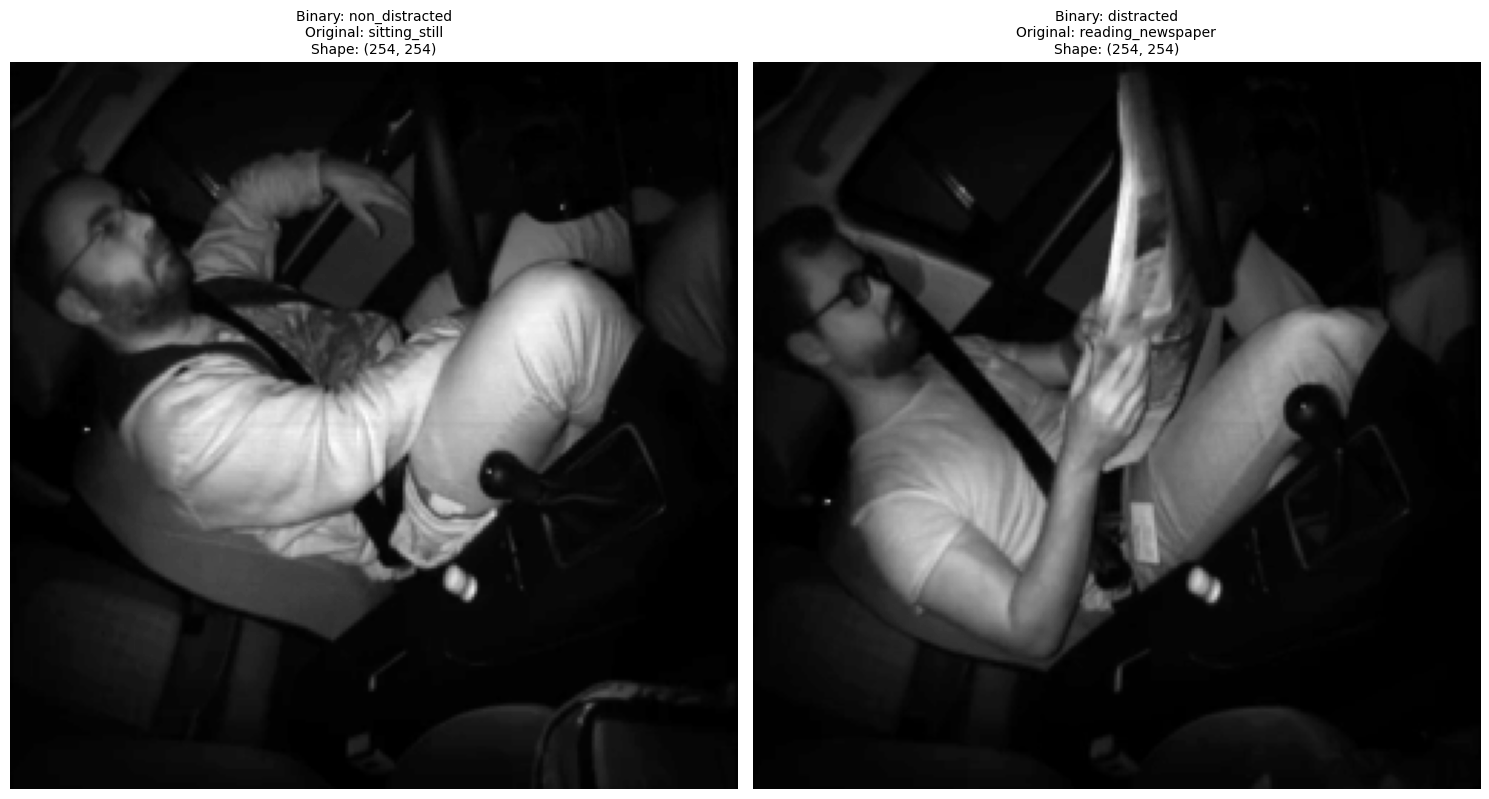

In [8]:
display_random_images(train_dataset, 
                      n=2,
                      classes=train_dataset.classes, 
                      seed=None)

In [9]:
train_dir = "/net/polaris/storage/deeplearning/sur_data/kinect_ir_daa/split_0/train"
val_dir = "/net/polaris/storage/deeplearning/sur_data/kinect_ir_daa/split_0/val"
test_dir = "/net/polaris/storage/deeplearning/sur_data/kinect_ir_daa/split_0/test"

train_dataset = BinaryClassificationDataset(train_dir, transform=combined_transforms)
test_dataset = BinaryClassificationDataset(test_dir, transform=combined_transforms)
val_dataset = BinaryClassificationDataset(val_dir, transform=combined_transforms)

train_indices = get_stratified_indices(train_dataset.all_binary_labels)
test_indices = get_stratified_indices(test_dataset.all_binary_labels)
val_indices = get_stratified_indices(val_dataset.all_binary_labels)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)
val_subset = Subset(val_dataset, val_indices)

# Analysis For Split_0: Train RGB Drive and ACT Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The random indexes chosen are: [32458, 47535]


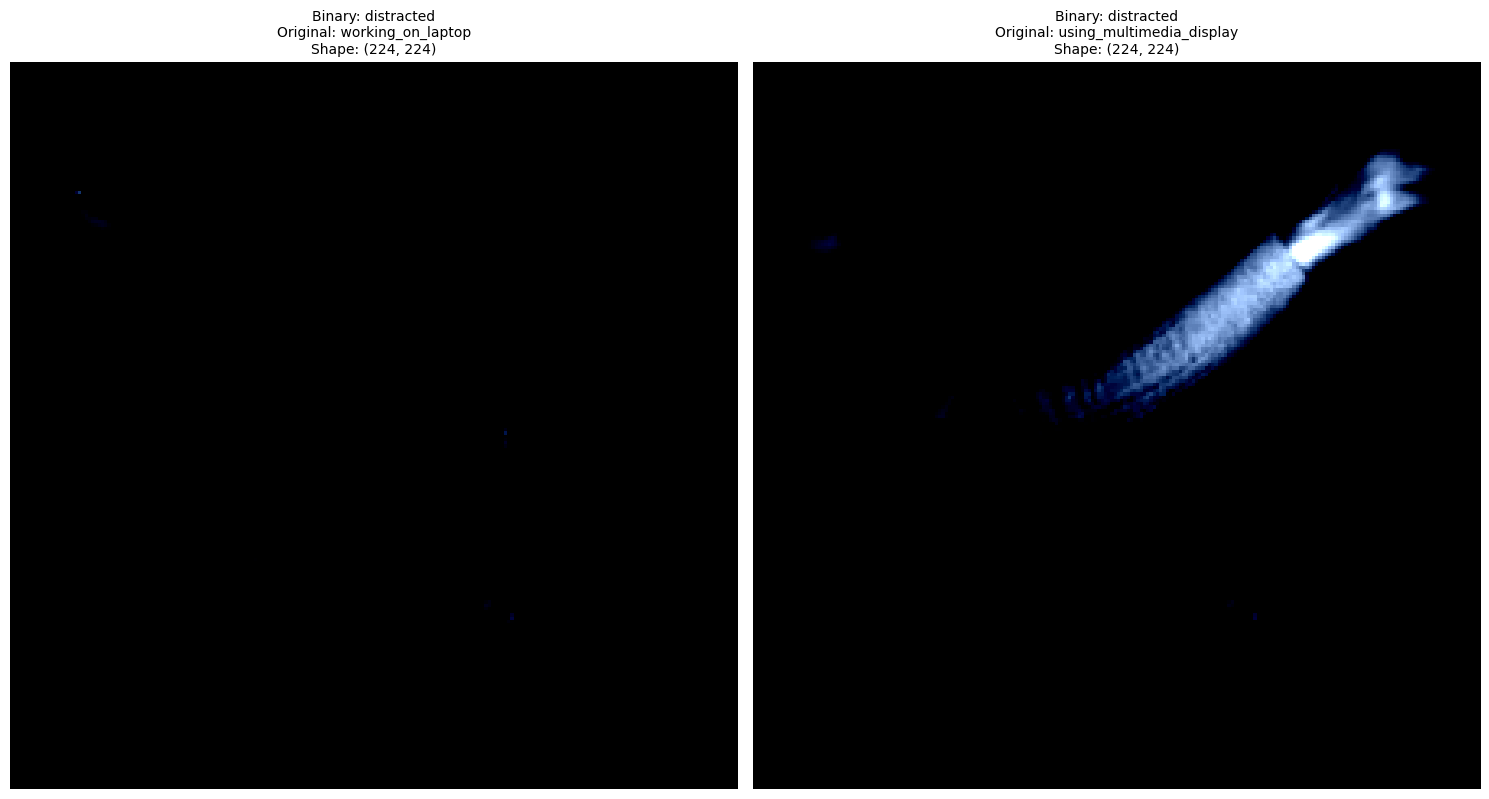

In [10]:
display_random_images(train_dataset, 
                      n=2,
                      classes=train_dataset.classes, 
                      seed=None)

{'non_distracted': 87758, 'distracted': 209827}
{'non_distracted': 0.2949006166305425, 'distracted': 0.7050993833694574}


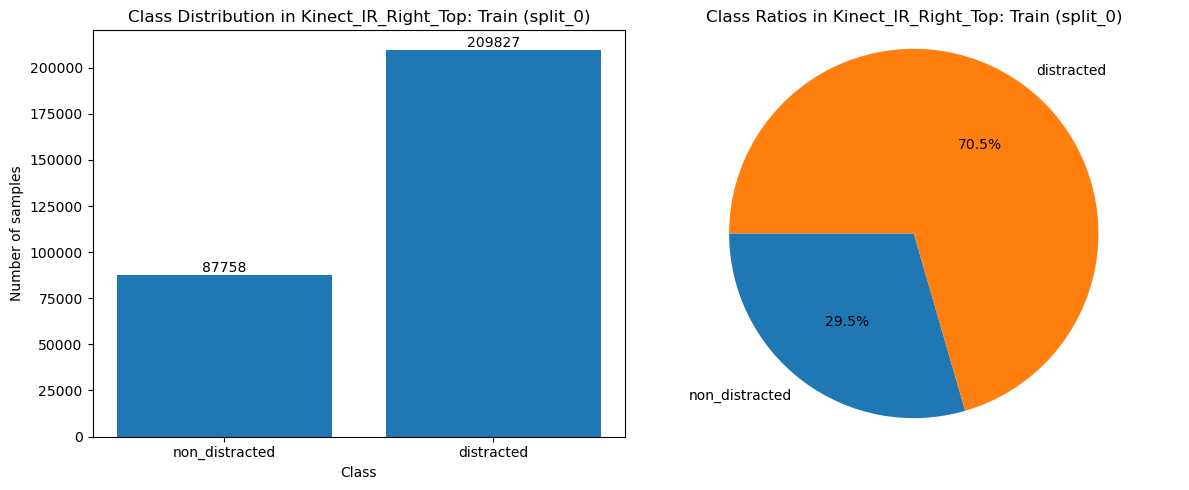

In [11]:
train_dataset = BinaryClassificationDatasetAnalysis(targ_dir=train_dir, dataset_name='Kinect_IR_Right_Top: Train', dataset_split="split_0")
# Print the counts and ratios
print(train_dataset.count_samples_per_class())
print(train_dataset.calculate_class_ratios())
train_dataset.plot_class_distribution()  # For the bar chart

# Train Subset from Split_0 DAA Train dataset

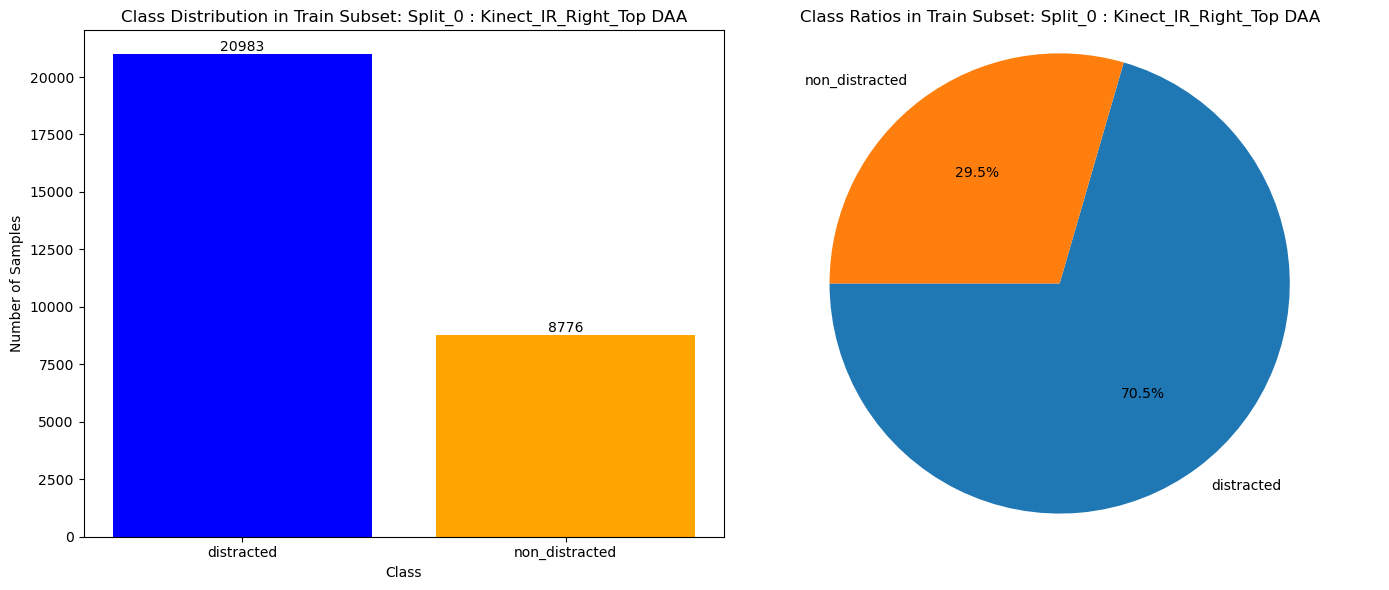

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_subset_distribution_and_ratios_combined(subset, all_binary_labels):
    # Extract indices from the subset
    subset_indices = subset.indices
    
    # Use these indices to access the corresponding labels directly from the pre-computed list/array
    subset_labels = [all_binary_labels[idx] for idx in subset_indices]
    
    # Count occurrences of each class in the subset
    class_counts = Counter(subset_labels)
    # Map numerical labels to class names
    class_names = {0: 'non_distracted', 1: 'distracted'}
    class_counts_named = {class_names[label]: count for label, count in class_counts.items()}
    
    # Calculate class ratios
    total_samples = sum(class_counts.values())
    class_ratios = {class_name: count / total_samples for class_name, count in class_counts_named.items()}
    
    # Setup figure and axes for both plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted for combined display
    
    # Plotting the distribution as a bar chart on the first subplot
    bars = axs[0].bar(class_counts_named.keys(), class_counts_named.values(), color=['blue', 'orange'])
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Number of Samples')
    axs[0].set_title('Class Distribution in Train Subset: Split_0 : Kinect_IR_Right_Top DAA')
    # Adding the count above each bar in the first subplot
    for i, (class_name, count) in enumerate(class_counts_named.items()):
        axs[0].text(i, count, str(count), ha='center', va='bottom')
    
    # Plotting the class ratios as a pie chart on the second subplot
    axs[1].pie(class_ratios.values(), labels=class_ratios.keys(), autopct='%1.1f%%', startangle=180)
    axs[1].set_title('Class Ratios in Train Subset: Split_0 : Kinect_IR_Right_Top DAA')
    axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout()
    plt.show()


plot_subset_distribution_and_ratios_combined(train_subset, train_dataset.all_binary_labels)

# EDA Analysis : Split_0 : RGB DAA : Test Dataset

{'non_distracted': 34347, 'distracted': 64799}
{'non_distracted': 0.34642849938474574, 'distracted': 0.6535715006152543}


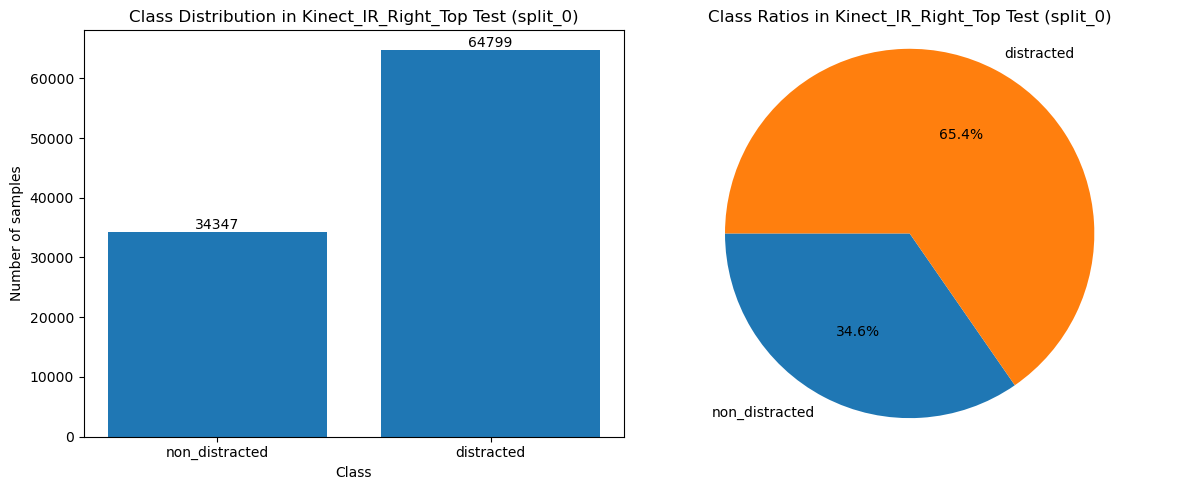

In [13]:
test_dataset = BinaryClassificationDatasetAnalysis(targ_dir=test_dir, dataset_name='Kinect_IR_Right_Top Test', dataset_split="split_0")
# Print the counts and ratios
print(test_dataset.count_samples_per_class())
print(test_dataset.calculate_class_ratios())
test_dataset.plot_class_distribution()  # For the bar chart

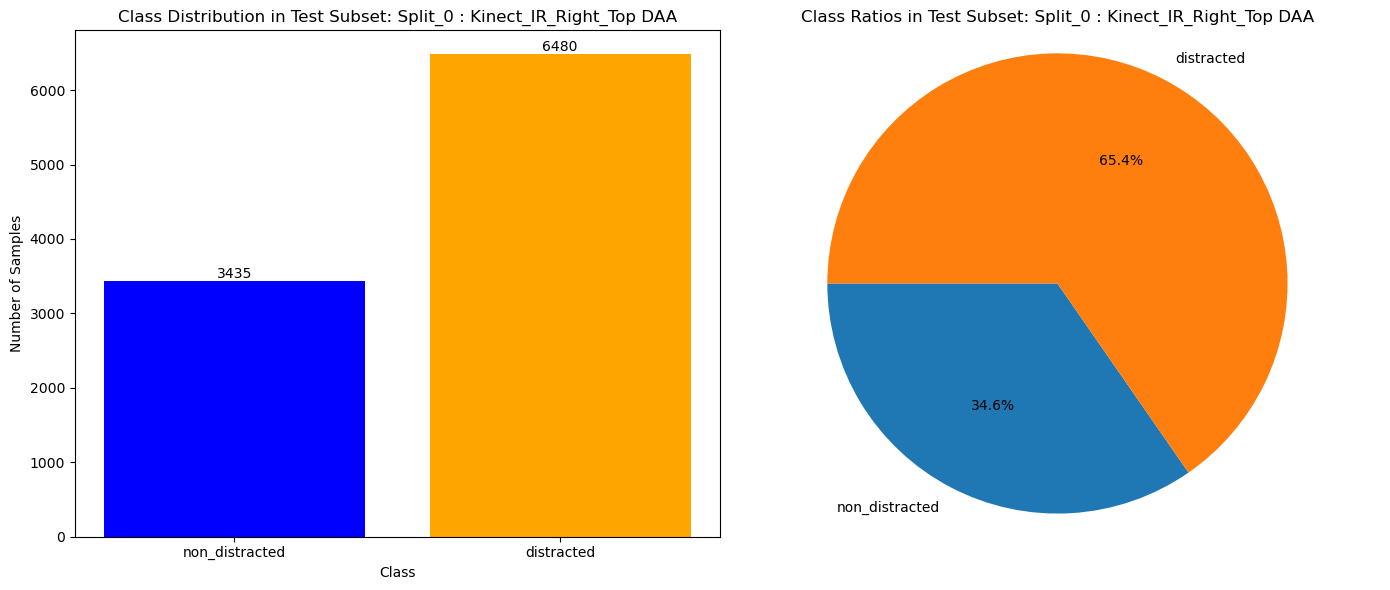

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_subset_distribution_and_ratios_combined(subset, all_binary_labels):
    # Extract indices from the subset
    subset_indices = subset.indices
    
    # Use these indices to access the corresponding labels directly from the pre-computed list/array
    subset_labels = [all_binary_labels[idx] for idx in subset_indices]
    
    # Count occurrences of each class in the subset
    class_counts = Counter(subset_labels)
    # Map numerical labels to class names
    class_names = {0: 'non_distracted', 1: 'distracted'}
    class_counts_named = {class_names[label]: count for label, count in class_counts.items()}
    
    # Calculate class ratios
    total_samples = sum(class_counts.values())
    class_ratios = {class_name: count / total_samples for class_name, count in class_counts_named.items()}
    
    # Setup figure and axes for both plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted for combined display
    
    # Plotting the distribution as a bar chart on the first subplot
    bars = axs[0].bar(class_counts_named.keys(), class_counts_named.values(), color=['blue', 'orange'])
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Number of Samples')
    axs[0].set_title('Class Distribution in Test Subset: Split_0 : Kinect_IR_Right_Top DAA')
    # Adding the count above each bar in the first subplot
    for i, (class_name, count) in enumerate(class_counts_named.items()):
        axs[0].text(i, count, str(count), ha='center', va='bottom')
    
    # Plotting the class ratios as a pie chart on the second subplot
    axs[1].pie(class_ratios.values(), labels=class_ratios.keys(), autopct='%1.1f%%', startangle=180)
    axs[1].set_title('Class Ratios in Test Subset: Split_0 : Kinect_IR_Right_Top DAA')
    axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout()
    plt.show()


plot_subset_distribution_and_ratios_combined(test_subset, test_dataset.all_binary_labels)

# EDA Analysis : Split_0 : RGB DAA : Validation Dataset

{'non_distracted': 13721, 'distracted': 50465}
{'non_distracted': 0.21376935780388245, 'distracted': 0.7862306421961175}


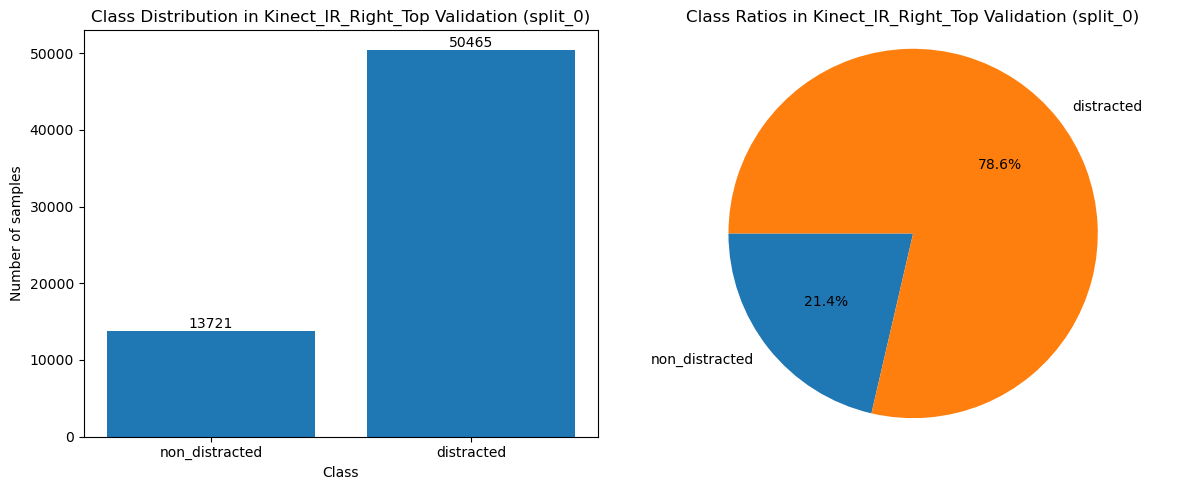

In [15]:
val_dataset = BinaryClassificationDatasetAnalysis(targ_dir=val_dir, dataset_name='Kinect_IR_Right_Top Validation', dataset_split="split_0")
# Print the counts and ratios
print(val_dataset.count_samples_per_class())
print(val_dataset.calculate_class_ratios())
val_dataset.plot_class_distribution()  # For the bar chart

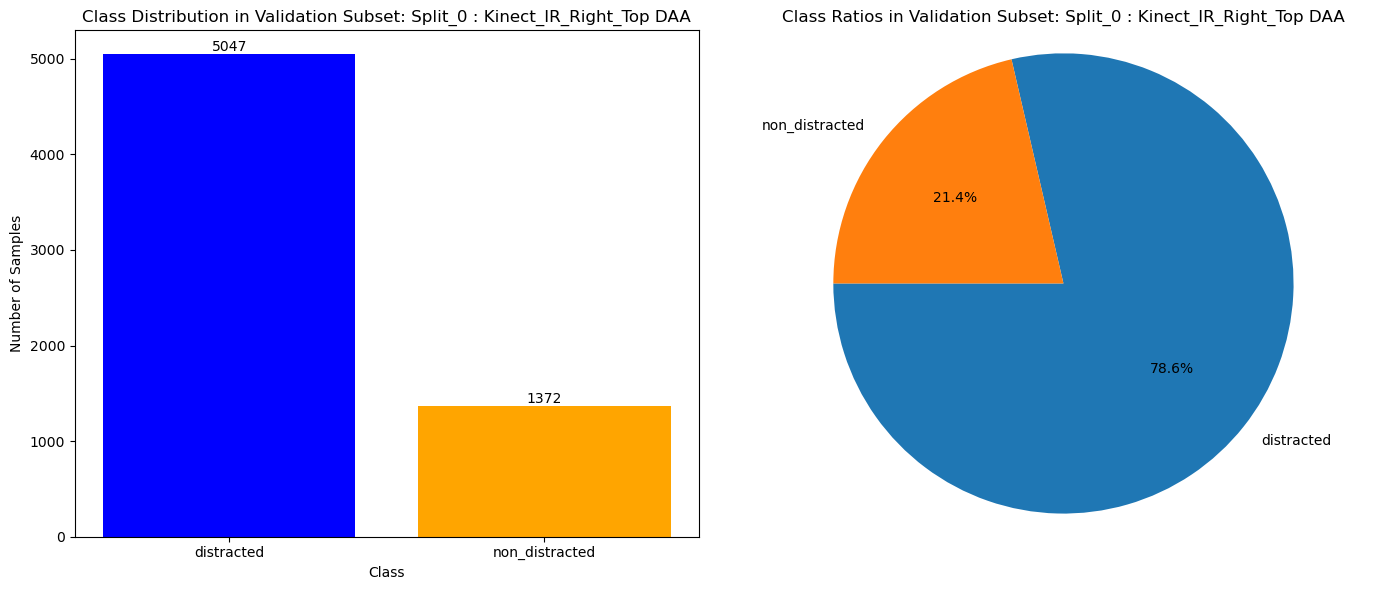

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_subset_distribution_and_ratios_combined(subset, all_binary_labels):
    # Extract indices from the subset
    subset_indices = subset.indices
    
    # Use these indices to access the corresponding labels directly from the pre-computed list/array
    subset_labels = [all_binary_labels[idx] for idx in subset_indices]
    
    # Count occurrences of each class in the subset
    class_counts = Counter(subset_labels)
    # Map numerical labels to class names
    class_names = {0: 'non_distracted', 1: 'distracted'}
    class_counts_named = {class_names[label]: count for label, count in class_counts.items()}
    
    # Calculate class ratios
    total_samples = sum(class_counts.values())
    class_ratios = {class_name: count / total_samples for class_name, count in class_counts_named.items()}
    
    # Setup figure and axes for both plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted for combined display
    
    # Plotting the distribution as a bar chart on the first subplot
    bars = axs[0].bar(class_counts_named.keys(), class_counts_named.values(), color=['blue', 'orange'])
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Number of Samples')
    axs[0].set_title('Class Distribution in Validation Subset: Split_0 : Kinect_IR_Right_Top DAA')
    # Adding the count above each bar in the first subplot
    for i, (class_name, count) in enumerate(class_counts_named.items()):
        axs[0].text(i, count, str(count), ha='center', va='bottom')
    
    # Plotting the class ratios as a pie chart on the second subplot
    axs[1].pie(class_ratios.values(), labels=class_ratios.keys(), autopct='%1.1f%%', startangle=180)
    axs[1].set_title('Class Ratios in Validation Subset: Split_0 : Kinect_IR_Right_Top DAA')
    axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout()
    plt.show()


plot_subset_distribution_and_ratios_combined(val_subset, val_dataset.all_binary_labels)